<a href="https://colab.research.google.com/github/SnipeHunting/MQ135-Air-Quality-with-ST7735-Display/blob/master/VaR_CVaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implement Value at Risk and Conditional Value at Risk using:


1.   Historical Method
2.   Parametric Method (Variance-Covariance)
3. Monte Carlo Method



In [21]:
import sys
#!{sys.executable} -m pip install yfinance --upgrade --no-cache-dir

#!{sys.executable} -m pip install fix_yahoo_finance

#!{sys.executable} -m pip install pandas_datareader --upgrade

import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import yfinance as yf
yf.pdr_override()

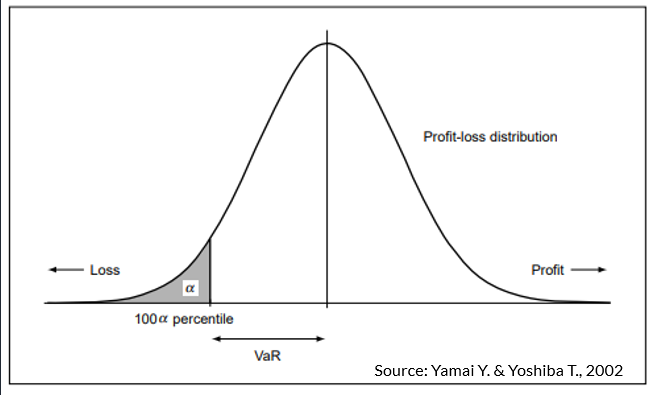

In [38]:
# Import data
def getData(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start=start, end=end)
#    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close'] 
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov() #Covariance of returns
    return returns, meanReturns, covMatrix

# Portfolio Performance
def portfolioPerformance(weights, meanReturns, covMatrix, Time):  #weights is of each stock in the protfolio allocation
    returns = np.sum(meanReturns*weights)*Time # returns are multiplied by time
    std = np.sqrt( np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time) # stdev calculation takes sqrt of the time
    return returns, std

stockList = ['AOS', 'LOW', 'HD', 'MCD', 'JNJ', 'ABT']
#stocks = [stock+'.AX' for stock in stockList] # for stocks in non US markets
stocks = [stock+'' for stock in stockList]
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800) 

returns, meanReturns, covMatrix = getData(stocks, start=startDate, end=endDate)
returns = returns.dropna() # dropping NA's because we calculate % change and there would be days with 1 degree of freedom

weights = np.random.random(len(returns.columns)) # assigning random values of protfolio allocation
weights /= np.sum(weights) # normalization of the weigths in order to have them all 100% 

#print(returns)

returns['portfolio'] = returns.dot(weights)

print(returns)

[*********************100%***********************]  6 of 6 completed
                                ABT       AOS        HD       JNJ       LOW  \
Date                                                                          
2020-11-24 00:00:00-05:00 -0.015192  0.008175  0.007038  0.000000  0.008395   
2020-11-25 00:00:00-05:00 -0.011151 -0.027433  0.002378 -0.001321 -0.000516   
2020-11-27 00:00:00-05:00  0.011371  0.012595  0.007410  0.002227 -0.001356   
2020-11-30 00:00:00-05:00  0.005575 -0.013490  0.005145  0.004722  0.007435   
2020-12-01 00:00:00-05:00  0.002495 -0.022199 -0.002920  0.019146 -0.015531   
...                             ...       ...       ...       ...       ...   
2023-01-24 00:00:00-05:00 -0.012981  0.007640  0.007005  0.000000  0.006338   
2023-01-25 00:00:00-05:00 -0.013596 -0.002472 -0.001353  0.007130 -0.001453   
2023-01-26 00:00:00-05:00  0.000631 -0.027594 -0.010874 -0.003658 -0.020863   
2023-01-27 00:00:00-05:00 -0.010084  0.025658  0.009178 -0.003

#Historical VaR

Here we make no assumptions about the distribution of returns.

In [87]:
def historicalVaR(returns, alpha=5):  # alpha is at 5% confidence intervak or 2stdev from the mean
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):  # in case the calculation is done for individual stock(type is series)
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):  # in case the calculation is done for protfolio (type is DateFrame)
        return returns.aggregate(historicalVaR, alpha=alpha) #evaluate the colume of each series and return aggregate of the historical VaR

    else:
        raise TypeError("Expected returns to be dataframe or series") # Error catching

#print(historicalVaR(returns,alpha=5))
#print(historicalVaR(returns['portfolio'],alpha=5))

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha) # check all the values if they are above or below VaR - we are interested now only at those below VaR and creating a subset of the data
        return returns[belowVaR].mean() # calculating the expectation of the mean of the below VaR loss

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

#print(historicalCVaR(returns,alpha=5)). # all the expectations should be below the VaR of 5%


# 365 days
Time = 365

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(Time)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(Time) # the risk
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time) #protfolio return

InitialInvestment = 100000

print('Expected Portfolio Return:       ${}'.format(round(InitialInvestment*pRet,2)), 'or {}% gain'.format( round(pRet*100,2)))  # defines the downside so we need to know the positive value
print('Value at Risk 95th CI.   :       ${}'.format(round(InitialInvestment*hVaR,2)), 'or {}% loss'.format( round(hVaR*100,2)))  # in those 95% we expect to lose that much
print('Conditional VaR 95th CI  :       ${}'.format(round(InitialInvestment*hCVaR,2)), 'or {}% loss'.format(round(hCVaR*100,2)))  # in those 5% we expect to lose that much


Expected Portfolio Return:       $13202.46 or 13.2% gain
Value at Risk 95th CI.   :       $29390.57 or 29.39% loss
Conditional VaR 95th CI  :       $41398.54 or 41.4% loss


#Parametric VaR

Here we make an assumption on the distribution of returns abd use the historical portfolio returns and standard deviations (estimates) to define parameters for the model. Here we have implemented two parametric VaR models:

*   Normal distribution
*   t-distribution (fatter tails)

t-distribution formula

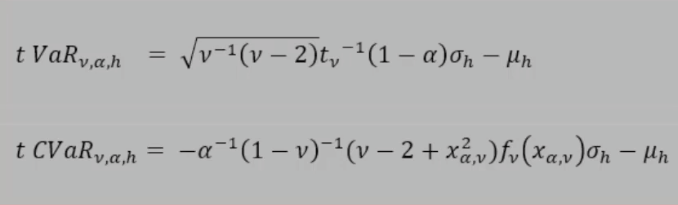

In [81]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):  #degreee of freedoms in the case of students distribution

    """  Calculate the portolio VaR given a distribution,with known parameters.
          We define the variables that describe the distribution   
          The variables will describe the distribution 
    """
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns  # percentil point function - looking for the point in which 95% of the data is on the right side
    elif distribution == 't-distribution': # 
        nu = dof # degrees of freedom
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'or't-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        x_anu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+x_anu**2) * t.pdf(x_anu, nu) * portfolioStd - portofolioReturns # use of probability density function
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print('Normal VaR 95th CI       :       ${}'.format(round(InitialInvestment*normVaR,2)))
print('Normal CVaR 95th CI       :      ${}'.format(round(InitialInvestment*normCVaR,2)))
print('t-dist VaR 95th CI       :       ${}'.format(round(InitialInvestment*tVaR,2)))
print('t-dist CVaR 95th CI      :       ${}'.format(round(InitialInvestment*tCVaR,2)))

Normal VaR 95th CI       :       $16857.62
Normal CVaR 95th CI       :      $24494.1
t-dist VaR 95th CI       :       $15793.03
t-dist CVaR 95th CI      :       $26201.97


#Monte Carlo VaR & CVaR

In this section we use a Monte Carlo simulation of a stock portfolio and then use the functions for historical VaR and CVaR to calculate our risk parameters.

The main advantage here is we could define individual models/stock dynamics for individual assets. This can be very powerful!

In [73]:
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 365 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    # MC loops
    Z = np.random.normal(size=(T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

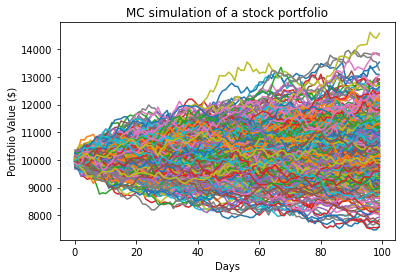

In [28]:
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [74]:
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")

In [88]:
portResults = pd.Series(portfolio_sims[-1,:]) # taking the very last element in the simulation

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))

VaR $2065.77
CVaR $2579.57


#Comparison of each VaR & CVaR methods

In [95]:
print('Expected Portfolio Return:       ${}'.format(round(InitialInvestment*pRet,2)), 'or {}% gain'.format( round(pRet*100,2)))  # defines the downside so we need to know the positive value

print("\nVaR:")
print('Historical VaR 95th CI   :       ${}'.format(round(InitialInvestment*hVaR,2)), 'or {}% gain'.format( round(hVaR*100,2)))  # in those 95% we expect to lose that much
print('Normal VaR 95th CI       :       ${}'.format(round(InitialInvestment*normVaR,2)), 'or {}% loss'.format(round(normVaR*100,2)))
print('t-dist VaR 95th CI       :       ${}'.format(round(InitialInvestment*tVaR,2)), 'or {}% loss'.format(round(tVaR*100,2)))
print('MC VaR  95th CI          :       ${}'.format(round(VaR,2)), 'or {}% loss'.format(round(VaR/InitialInvestment*100,2)))

print("\nCVaR:")
print('historical CVaR 95th CI   :       ${}'.format(round(InitialInvestment*hCVaR,2)), 'or {}% gain'.format(round(hCVaR*100,2)))  # in those 5% we expect to lose that much
print('Normal CVaR 95th CI       :       ${}'.format(round(InitialInvestment*normCVaR,2)), 'or {}% loss'.format(round(normCVaR*100,2)))
print('t-dist CVaR 95th CI       :       ${}'.format(round(InitialInvestment*tCVaR,2)), 'or {}% loss'.format(round(tCVaR*100,2)))
print('MC CVaR  95th CI          :       ${}'.format(round(CVaR,2)), 'or {}% loss'.format(round(CVaR/InitialInvestment*100,2)))


Expected Portfolio Return:       $13202.46 or 13.2% gain

VaR:
Historical VaR 95th CI   :       $29390.57 or 29.39% gain
Normal VaR 95th CI       :       $16857.62 or 16.86% loss
t-dist VaR 95th CI       :       $15793.03 or 15.79% loss
MC VaR  95th CI          :       $2065.77 or 2.07% loss

CVaR:
historical CVaR 95th CI   :       $41398.54 or 41.4% gain
Normal CVaR 95th CI       :       $24494.1 or 24.49% loss
t-dist CVaR 95th CI       :       $26201.97 or 26.2% loss
MC CVaR  95th CI          :       $2579.57 or 2.58% loss
